In [37]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import os

In [32]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

#sepreate out the likely wood part by color, (find gray color)
def wood_part(image, value_diff, maximum , minimum):
    wood_im = image.copy()
    height,width,depth = wood_im.shape
    print(wood_im.shape)
    for i in range(0,height):
        for j in range(0,width):
#             print(wood_im[i,j,:])
            mini = wood_im[i,j,:].min()
            maxi = wood_im[i,j,:].max()
            blue = wood_im[i,j,0]
            green = wood_im[i,j,1]
            red = wood_im[i,j,2]
            #for gray color
            if (mini > minimum and (maxi - mini < value_diff) and maxi < maximum):
                continue
#                 print(wood_im[i,j,:])
            #for brown color
            elif ((red > 80 and red < 240) 
                     and (red > green + 15 and red < green + 45) 
                     and (green > blue+15 and green < blue +45)):
                continue
            else:
                wood_im[i,j,:] = (0,0,0)

    return wood_im
# #sepreate out the likely wood part by color, (find gray color)
# def wood_part(image, value_diff, maximum , minimum):
#     wood_im = image.copy()
#     height,width,depth = wood_im.shape
#     print(wood_im.shape)
#     for i in range(0,height):
#         for j in range(0,width):
# #             print(wood_im[i,j,:])
#             mini = wood_im[i,j,:].min()
#             maxi = wood_im[i,j,:].max()
# #             print(mini)
# #             print(maxi)
#             if (mini > minimum and (maxi - mini < value_diff) and maxi < maximum):
#                 continue
# #                 print(wood_im[i,j,:])
#             else:
#                 wood_im[i,j,:] = (0,0,0)

#     return wood_im


#noise removal of gray image
def noise_remove(image):
    image_out = image.copy()
    image_out = cv2.GaussianBlur(image_out, (3, 3), cv2.THRESH_BINARY)
    # gray = cv2.equalizeHist(gray)
#     plt.imshow(image_out,'gray')
#     plt.show()

    img_bw = image_out.copy()

    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

    mask = cv2.morphologyEx(image_out, cv2.MORPH_OPEN, se1)
    out = image_out * mask
#     plt.imshow(out,'gray')
#     plt.show()

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, se2)
    out = out * mask
    return out

#draw contours on original image
def draw_controus_box(binary_image,original_image):
    cnts = cv2.findContours(binary_image.copy(), cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    orig = original_image.copy()
    # loop over the contours individually
    for c in cnts:
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 2500:
            continue
        # compute the rotated bounding box of the contour

        box = cv2.minAreaRect(c)
    #     print(box)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
    #     # order the points in the contour such that they appear
    #     # in top-left, top-right, bottom-right, and bottom-left
    #     # order, then draw the outline of the rotated bounding
    #     # box
    #     box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
        # loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 5, (0, 0, 255), -1)
        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)
        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)
        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
            (255, 0, 255), 2)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
            (255, 0, 255), 2)

    print("boxed contours")
    plt.imshow(orig)
    plt.show()
    
#draw contours and remove small contours 
#return filled contour for area calculation
def draw_contours(binary_image):
    dx, dy = binary_image.shape
    cnts = cv2.findContours(binary_image.copy(), cv2.CHAIN_APPROX_NONE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    test = np.zeros((dx, dy),dtype=np.uint8)
    filled = np.zeros((dx, dy),dtype=np.uint8)
    counter = 0
    orig = test
    # loop over the contours individually
    for c in cnts:
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < 1500:
            continue
        counter = counter +1
        orig = cv2.drawContours(orig, c, -1, (255, 255,255), 2)
        cv2.fillPoly(filled, pts = [c], color=(255,255,255)) 

    print(counter)
    plt.imshow(out,'gray')
    plt.show()

    plt.imshow(orig,'gray')
    plt.show()

    plt.imshow(filled,'gray')
    plt.show()

    test = np.zeros((dx, dy),dtype=np.uint8)
    test = cv2.drawContours(test, cnts, -1, (255, 255,255), 2)
    plt.imshow(test)
    plt.show()
    return filled

def white_area_cal_percentage(gray_image):
    white_area = gray_image.sum()/255
    dx,dy = gray_image.shape
    return white_area/(dx*dy)*100


--------start process--------
-----------------------------


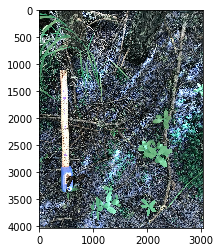

(4032, 3024, 3)
dead wood region computing


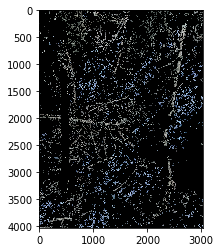

gray scale, noise removed image


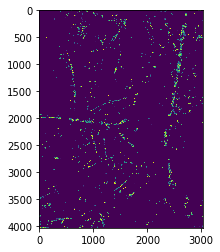

boxed contours


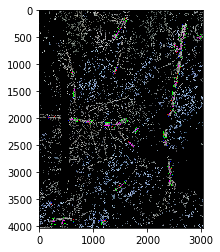

46


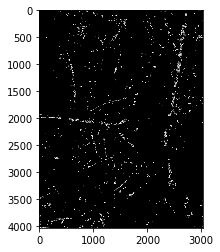

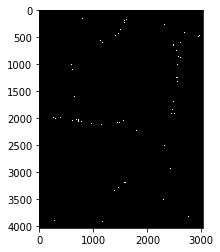

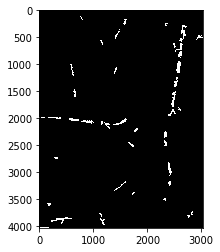

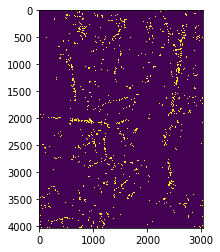

1.8447984903838077 %


In [45]:
# def main():
    #parameters
    
print("--------start process--------")
print("-----------------------------")


#read image 
#     image = cv2.imread('ground-fuel-example3.jpg')
image = cv2.imread('19-PM42123427-2Dc.jpg')
# image = cv2.imread('19-PM42653427-1Db.jpg')
plt.imshow(image)
plt.show()
#     dx,dy,dc = image.shape

#find dead wood region
#by experiences the dead wood part normally (gray color) have close rgb value max-min ~<10    wood_pre = wood_part(image,10,230,65)
wood_pre = wood_part(image,12,205,55)
print("dead wood region computing")
plt.imshow(wood_pre)
plt.show()

#convert to gray scale and remove noise
image = wood_pre.copy()
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
out = noise_remove(gray)
print("gray scale, noise removed image")
plt.imshow(out)
plt.show()

# #draw contour
# draw_controus_box(out,image)

#draw filled contour
filled = draw_contours(out)

#calculate percentage of dead wood
area_percent = white_area_cal_percentage(filled)
print(area_percent,"%")

In [5]:
# if __name__ == "__main__":
#     main()

In [56]:
#read files 
output_image_path = "/home/linjian/projects/ground_fuel/data/DeadWoodExtracted/"
images_path = "/home/linjian/projects/ground_fuel/data/SamplePhotos/"
wood_area_path = "/home/linjian/projects/ground_fuel/data/WoodArea.txt"
images_list = sorted(os.listdir(images_path))

f = open(wood_area_path,"w+")
# for i in range(len(images_list)):
for i in range(10):
    if(images_list[i].endswith(".jpg")):
        dir_in = images_path+images_list[i]
        dir_out = outpu_image_path+images_list[i]
        image = cv2.imread(dir_in)
        cv2.imwrite(dir_out, image) 
        
        f.write(images_list[i])
        f.write("   ")
        f.write(str(area_percent) + "%" + "\n")
#         break
f.close()

In [7]:

# image = wood_pre.copy()
# gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# out = noise_remove(gray)

In [8]:

# draw_controus_box(out,image)

In [9]:

# filled = draw_contours(out)

In [10]:

# print(white_area_cal_percentage(filled),"%")